In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline

In [2]:
# Load dataset
#df = pd.read_csv("C:/Users/T8665/OneDrive - LTIMindtree/Desktop/Expiry_risk_project/data/processed/processed_data.csv")
df = pd.read_csv("/Users/sakshizanjad/Desktop/grocery_expiry_project/data/processed/processed_data.csv")

In [3]:
# Clean and convert Unit_Price to float
df['Unit_Price'] = df['Unit_Price'].replace(r'[\$,]', '', regex=True).astype(float)

# Convert date columns (as requested, without loop)
df['Date_Received'] = pd.to_datetime(df['Date_Received'], errors='coerce')
df['Last_Order_Date'] = pd.to_datetime(df['Last_Order_Date'], errors='coerce')
df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'], errors='coerce')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4470 entries, 0 to 4469
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Product_ID                  4470 non-null   object        
 1   Product_Name                4470 non-null   object        
 2   Category                    4470 non-null   object        
 3   Supplier_ID                 4470 non-null   object        
 4   Supplier_Name               4470 non-null   object        
 5   Stock_Quantity              4470 non-null   int64         
 6   Reorder_Level               4470 non-null   int64         
 7   Reorder_Quantity            4470 non-null   int64         
 8   Unit_Price                  4470 non-null   float64       
 9   Date_Received               1769 non-null   datetime64[ns]
 10  Last_Order_Date             4470 non-null   datetime64[ns]
 11  Expiration_Date             1741 non-null   datetime64[n

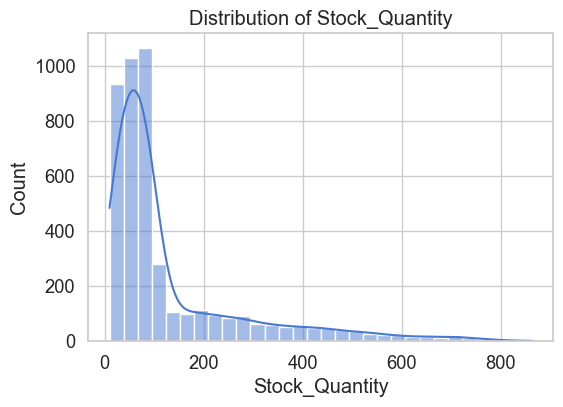

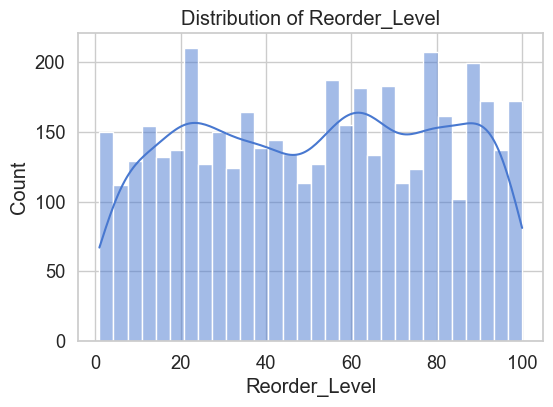

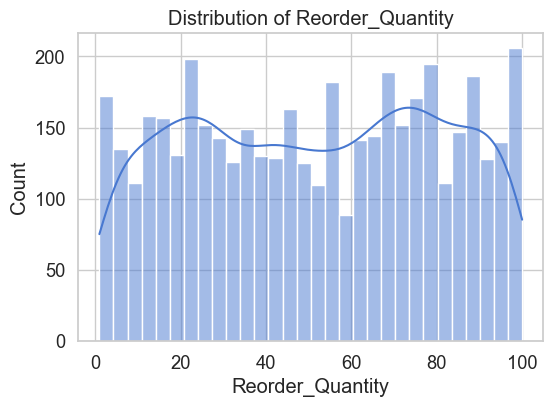

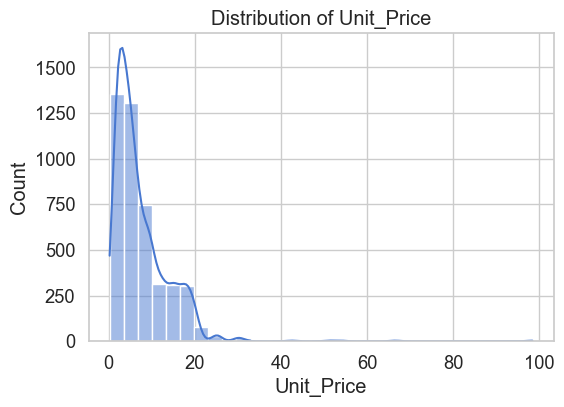

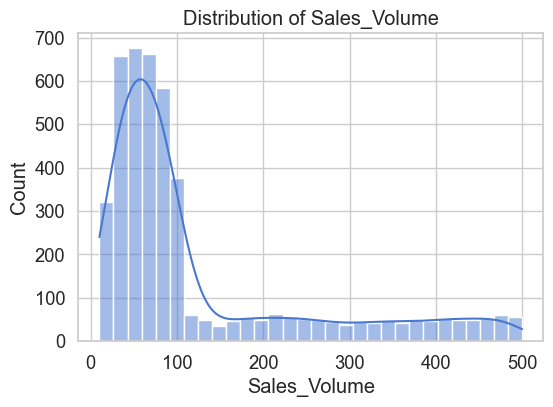

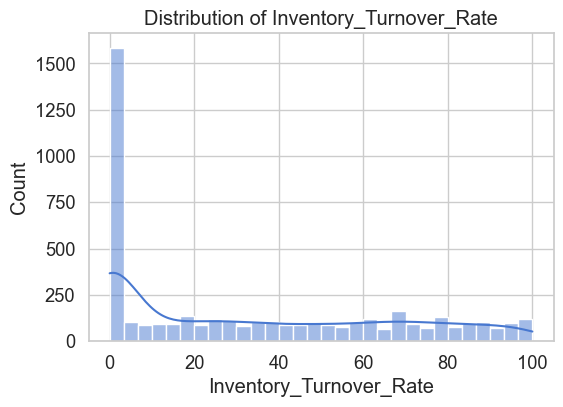

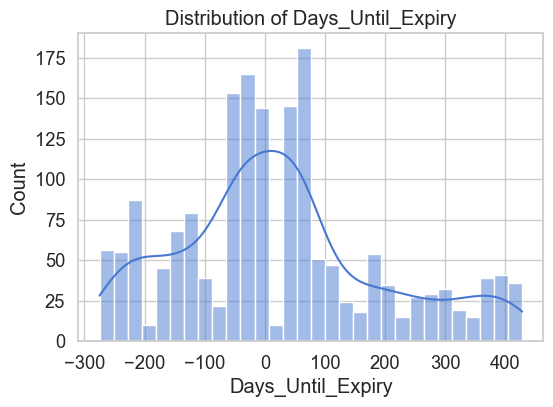

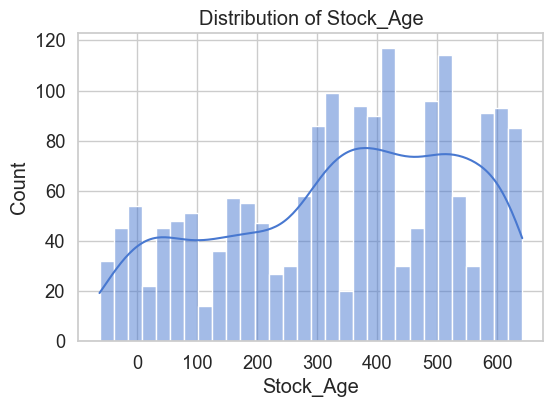

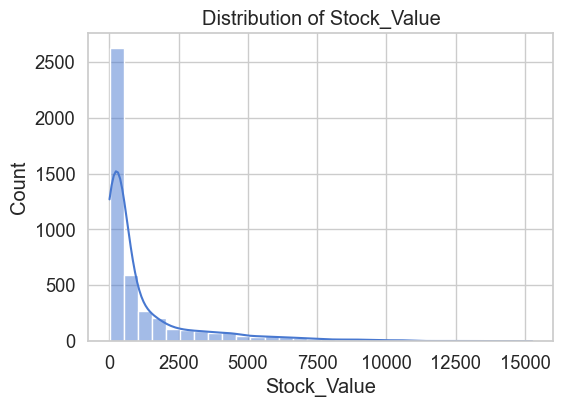

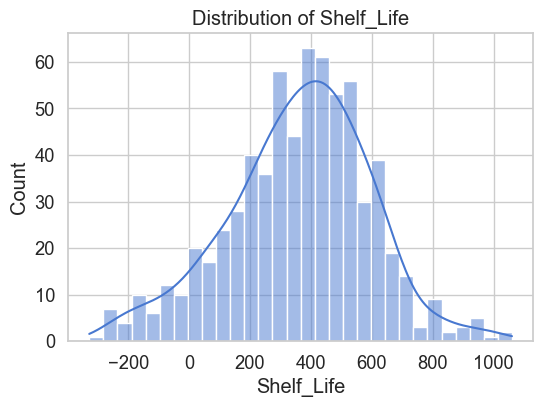

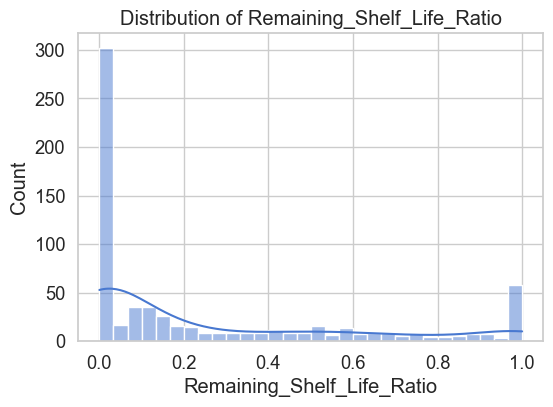

In [5]:
#Numerical feature distributions
num_cols = ['Stock_Quantity', 'Reorder_Level', 'Reorder_Quantity', 'Unit_Price', 'Sales_Volume',
            'Inventory_Turnover_Rate', 'Days_Until_Expiry', 'Stock_Age', 'Stock_Value', 'Shelf_Life', 'Remaining_Shelf_Life_Ratio']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

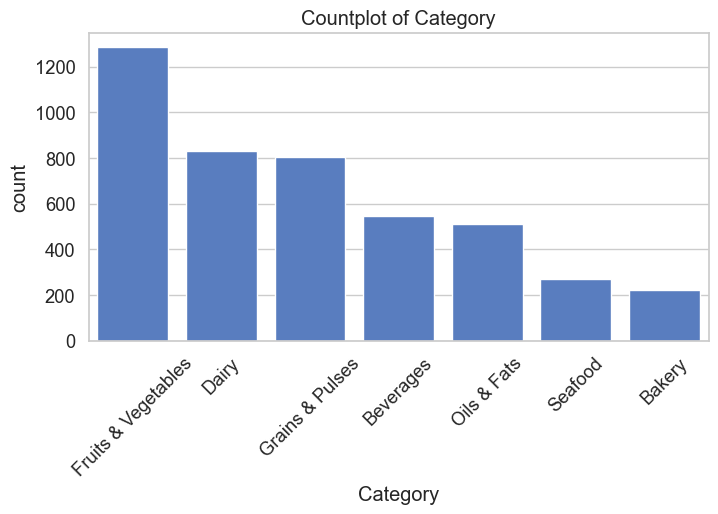

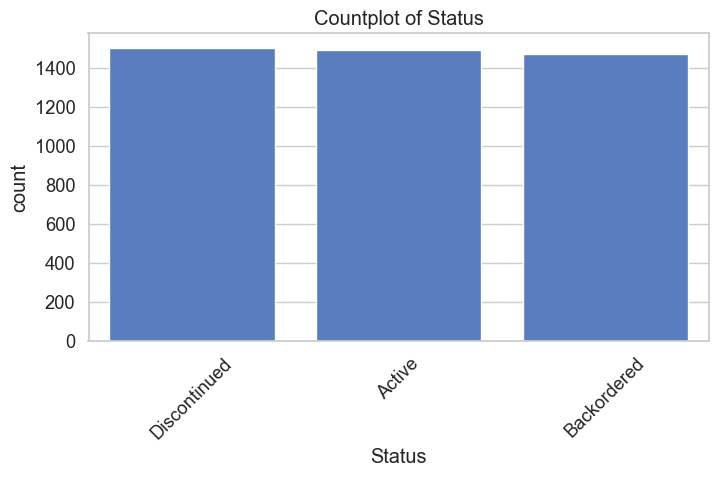

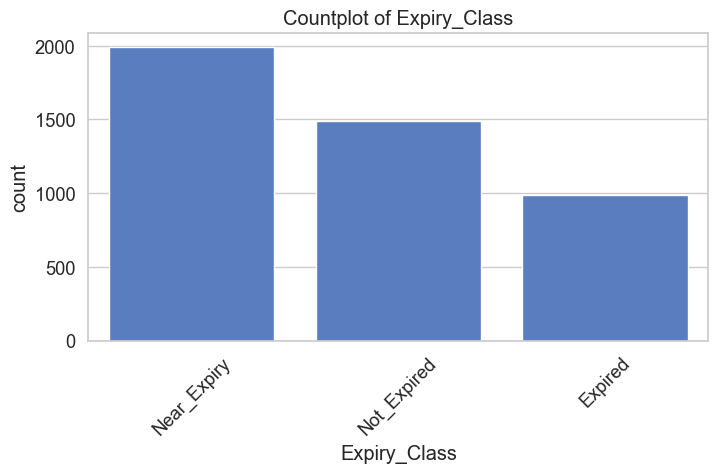

In [6]:
#Categorical feature distributions
cat_cols = ['Category', 'Status', 'Expiry_Class']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Countplot of {col}')
    plt.show()

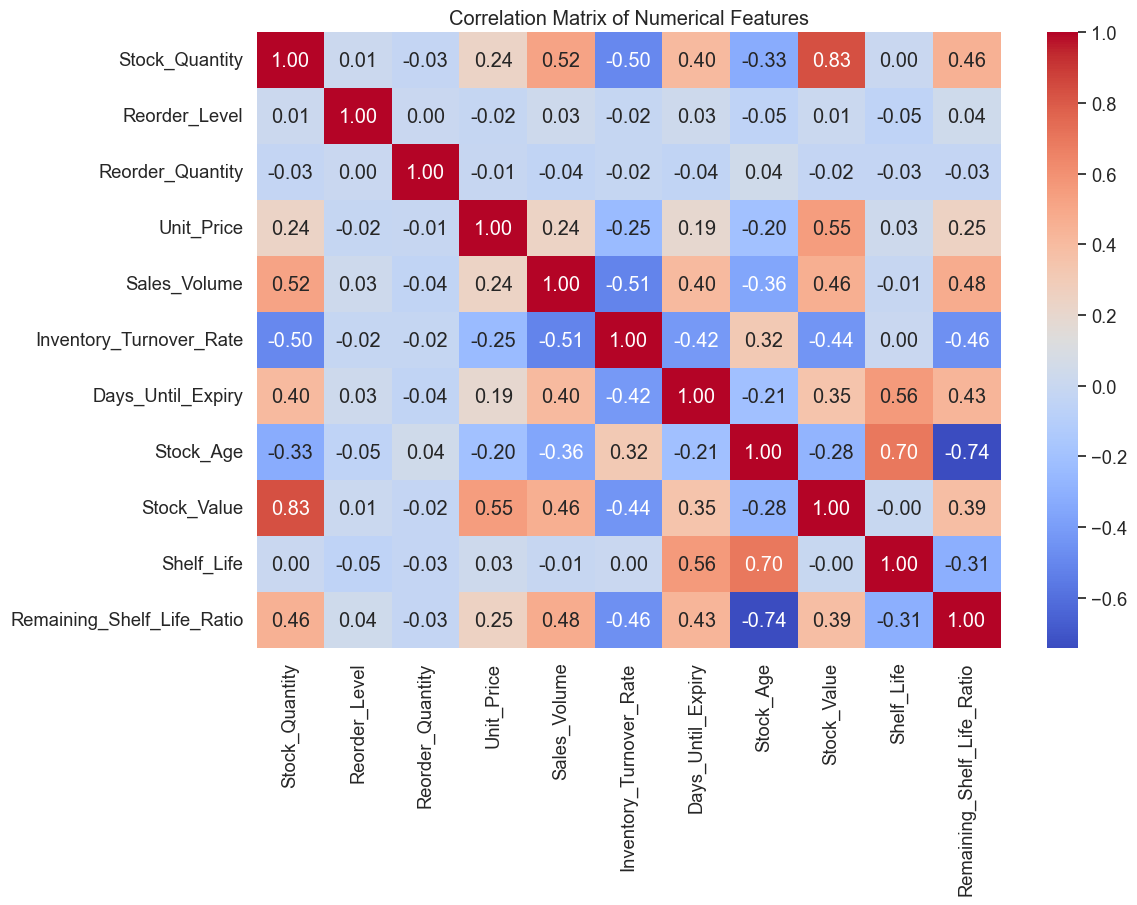

In [7]:
#Correlation analysis
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Hypothesis Testing

In [8]:
#Chi-square test for Category vs Expiry_Class
cont_table = pd.crosstab(df['Category'], df['Expiry_Class'])
chi2, p, dof, ex = chi2_contingency(cont_table)
print(f'Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}')
if p < 0.05:
    print('Category and Expiry_Class are dependent')
else:
    print('Category and Expiry_Class are independent')

Chi-square statistic: 98.81, p-value: 0.0000
Category and Expiry_Class are dependent


Product **Category** and **Expiry_Class** are **dependent**, meaning product type influences expiry status.

Numeric features: 
Stock_Quantity, Reorder_Level, Reorder_Quantity, Unit_Price, Sales_Volume,
Inventory_Turnover_Rate, Days_Until_Expiry, Stock_Age, Stock_Value, Shelf_Life, Remaining_Shelf_Life_Ratio

In [9]:
#ANOVA for numeric features vs Expiry_Class
import pandas as pd
from scipy.stats import f_oneway

# Select numeric features (excluding any IDs)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Product_ID', 'Supplier_ID']]

anova_results = []

# Loop through numeric features and perform ANOVA
for feature in numeric_features:
    groups = [df[df['Expiry_Class']==cls][feature].dropna() for cls in df['Expiry_Class'].unique()]
    
    # Only perform ANOVA if there are at least 2 groups with data
    if all(len(g) > 0 for g in groups):
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({'Feature': feature, 'F-Statistic': f_stat, 'p-value': p_val})

# Convert results to DataFrame
anova_df = pd.DataFrame(anova_results).sort_values('p-value')

# Mark significant features
anova_df['Significant'] = anova_df['p-value'] < 0.05

print(anova_df)

                       Feature  F-Statistic        p-value  Significant
0               Stock_Quantity   474.336492  1.577329e-187         True
8                  Stock_Value   333.650972  8.920935e-136         True
4                 Sales_Volume   223.645215   2.709504e-93         True
5      Inventory_Turnover_Rate   205.973977   2.717033e-86         True
6            Days_Until_Expiry   182.470055   1.165928e-72         True
3                   Unit_Price    41.408168   1.518206e-18         True
7                    Stock_Age    40.554016   6.026836e-18         True
10  Remaining_Shelf_Life_Ratio    27.425660   3.540468e-12         True
9                   Shelf_Life     4.065032   1.758498e-02         True
2             Reorder_Quantity     0.415213   6.602251e-01        False
1                Reorder_Level     0.348212   7.059686e-01        False


Most numeric features significantly vary across expiry classes, except for reorder-related variables and stock age.

In [10]:
#chi-square test for categorical features vs Expiry_Class
import pandas as pd
from scipy.stats import chi2_contingency

# Select categorical features (excluding IDs and names)
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['Product_ID', 'Product_Name', 'Supplier_ID', 'Supplier_Name', 'Warehouse_Location']]

chi2_results = []

# Loop through categorical features and perform Chi-square test
for feature in categorical_features:
    contingency = pd.crosstab(df[feature], df['Expiry_Class'])
    
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:  # ensure valid table
        chi2, p, dof, expected = chi2_contingency(contingency)
        chi2_results.append({'Feature': feature, 'Chi2-Statistic': chi2, 'p-value': p})

# Convert results to DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Mark significant features
chi2_df['Significant'] = chi2_df['p-value'] < 0.05

print(chi2_df)

        Feature  Chi2-Statistic       p-value  Significant
2  Expiry_Class     8940.000000  0.000000e+00         True
0      Category       98.805030  9.541508e-16         True
1        Status        1.106816  8.931892e-01        False


Product **Category** is an important predictor of expiry, while **Status** has no meaningful association.